# Developing SED module

## Motivation
This module is designed to deal with realistic galaxy SED. Some realism should be considered are

- Continuum template with flexible renormalization
- Emission line with flexible renormalization
- Physical SED units, can be used for ETC
- Provide a static interpolator API for building 3D model datacube 

Note: we do not need `EmissionLine` class actually, maybe just a SED class which wraps the GalSim SED class.

## Arguments

An SED object is constructed by passing a dictionary argument, which contains the following keywords:

- `template`: indicating which continuum template to use for generating simulated grism image. The `template` file should contains two columns, one for wavelength in units of `wave_type` (e.g. `nm/nanometer/nanometers` or `a/ang/angstrom/angstroms` etc.), and one for SED of type `flux_type` (e.g. `flambda` or `fnu` or `fphotons`). Note that `wave_type` and `flux_type` are directly passed to GalSim `SED` object
- `z`: redshift
- `spectral_range`: the observer-frame spectral range of the SED, in units of `nm`
- `obs_cont_norm`: (`lam`, `flux`) tupple, continuum normalized to `flux` `erg/s/cm2/nm` at `lam` `nm`.
- `lines`: dict, with keyword in (`Halpha`, `OII`, `OIII`) and values the flux in `erg/s/cm2`
- `line_sigma_int`: dict, with keyword in (`Halpha`, `OII`, `OIII`) and values the intrinsic Gaussian line std in `nm`

## Attributes and Methods

An SED object should has the following attributes:

- `pars`: parameters to generate SED
- `spectrum`: galsim SED object, used as spectrum interpolant

An SED object should has the following methods:

- `__init__`: initializing the Spectrum object with parameter dict
- `updatePars`: update parameters by passing a new params dict
- `_addContinuum`: build continuum SED out of template file
- `_addEmissionLines`: build emission lines SED out of Gaussian profile

In [93]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import corner
import zeus
from astropy.units import Unit
import astropy.units as units
import astropy.constants as constants
import sys
sys.path.append('../../kl_tools/')
import basis, cube, intensity, likelihood, mcmc, parameters, priors, utils, velocity
#from likelihood_grism_test import _interp2d
import scipy
from scipy import interpolate
import galsim
#%matplotlib inline

In [186]:
class Spectrum(object):
    '''
    This class describe the obs-frame SED template of a source galaxy, includ-
    ing emission lines and continuum components.
    This is mostly a wrapper of the galsim.SED class object
    
    Note that this class should only capture the intrinsic properties of
    the galaxy SED, like
        - redshift
        - continuum and emission line flux density
        - emission line width
        - [dust?]
    Other extrinsic properties, like
        - sky background
        - system bandpass
        - spectral resolution and dispersion
        - exposure time
        - collecting area
        - pixelization
        - noise
    will be implemented in mock observation module
    '''
    ### settings for the whole class
    # default parameters
    _default_pars = {
        'template': '../../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 0.0,
        'spectral_range': (50, 50000), # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': (400, 0.),
        # spectral resolution at 1 micron, assuming dispersion per pixel
        #'resolution': 3000,
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines': {'Halpha': 1e-15,},
        # intrinsic linewidth in nm
        'line_sigma_int': {'Halpha': 0.5,},
        #'line_hlr': (0.5, Unit('arcsec')),
    }
    # units conversion
    _h = constants.h.to('erg s').value
    _c = constants.c.to('nm/s').value
    # build-in emission line species and info
    _valid_lines = {
        'Halpha': 656.461,
        'OII': [372.7092, 372.9875],
        'OIII': [496.0295, 500.8240],
    }
    
    def __init__(self, pars, rel_err=-1):
        '''
        Initialize SED class object with parameters dictionary
        '''
        self.pars = Spectrum._default_pars.copy()
        self.updatePars(pars)
        continuum = self._addContinuum()
        emission = self._addEmissionLines()
        self.spectrum = continuum + emission
        if rel_err>0:
            self.spectrum = self.spectrum.thin(rel_err=rel_err)
        
        
    def updatePars(self, pars):
        '''
        Update parameters
        '''
        for key, val in pars.items():
            self.pars[key] = val

    def _addContinuum(self):
        '''
        Build and return continuum GalSim SED object
        '''
        template = self.pars['template']
        if not os.path.isfile(template):
            raise OSError(f'Can not find template file {template}!')
        # build GalSim SED object out of template file
        _template = np.genfromtxt(template)
        _table = galsim.LookupTable(x=_template[:,0], f=_template[:,1],)
        SED = galsim.SED(_table, 
                         wave_type=self.pars['wave_type'], 
                         flux_type=self.pars['flux_type'],
                         redshift=self.pars['z'],
                         _blue_limit=self.pars['spectral_range'][0],
                         _red_limit=self.pars['spectral_range'][1])
        # normalize the SED object at observer frame
        # erg/s/cm2/nm -> photons/s/cm2/nm
        # TODO: add more flexible normalization parametrization
        norm = self.pars['obs_cont_norm'][1]*self.pars['obs_cont_norm'][0]/\
            (Spectrum._h*Spectrum._c)
        return SED.withFluxDensity(target_flux_density=norm, 
                                   wavelength=self.pars['obs_cont_norm'][0])
    
    def _addEmissionLines(self):
        '''
        Build and return Gaussian emission lines GalSim SED object
        '''
        # init LookupTable for rest-frame SED
        lam_grid = np.arange(self.pars['spectral_range'][0]/(1+self.pars['z']),
                             self.pars['spectral_range'][1]/(1+self.pars['z']), 0.1)
        flux_grid = np.zeros(lam_grid.size)
        # Set emission lines: (specie, observer frame flux)
        all_lines = Spectrum._valid_lines.keys()
        norm = -1
        for line, flux in self.pars['lines'].items():
            # sanity check
            rest_lambda = np.atleast_1d(Spectrum._valid_lines[line])
            flux = np.atleast_1d(flux)
            line_sigma_int = np.atleast_1d(self.pars['line_sigma_int'][line])
            if rest_lambda is None:
                raise ValueError(f'{line} is not a valid emission line! '+\
                        f'For now, line must be one of {all_lines}')
            else:
                assert rest_lambda.size == flux.size, f'{line} has'+\
                f' {rest_lambda.size} lines but {flux.size} flux are provided!'
            # build rest-frame f_lambda SED [erg s-1 cm-2 nm-1]
            # then, redshift the SED. The line width will increase automatically
            for i,cen in enumerate(rest_lambda):
                _lw_sq = line_sigma_int[i]**2
                # erg/s/cm2 -> erg/s/cm2/nm
                _norm = flux[i]/np.sqrt(2*np.pi*_lw_sq)
                flux_grid += _norm * np.exp(-(lam_grid-cen)**2/(2*_lw_sq))
                # also, calculate normalization factor for obs-frame spectrum
                # convert flux units: erg/s/cm2/nm -> photons/s/cm2/nm
                # only one emission line needed
                if(norm<0):
                    norm_lam = cen*(1+self.pars['z'])
                    norm = flux[i]*norm_lam/(Spectrum._h*Spectrum._c)/\
                                np.sqrt(2*np.pi*_lw_sq*(1+self.pars['z'])**2)
            
        _table = galsim.LookupTable(x=lam_grid, f=flux_grid,)
        SED = galsim.SED(_table,
                         wave_type='nm',
                         flux_type='flambda',
                         redshift=self.pars['z'],)
        # normalize to observer-frame flux
        SED = SED.withFluxDensity(target_flux_density=norm, 
                                  wavelength=norm_lam)
        return SED

In [200]:
# generate an SED object
pars = {
        'template': '../../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 1.0,
        'spectral_range': (500, 1930), # nm
        # observer frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': (1300, 1e-17),
        # spectral resolution at 1 micron, assuming dispersion per pixel
        #'resolution': 3000,
        # a dict of line names and flux values (erg/s/cm2)
        'lines': {'Halpha': 1e-15,
                  'OII': [1e-14, 1e-14],
                  'OIII': [1e-14, 1e-14]},
        # intrinsic linewidth in nm
        'line_sigma_int': {'Halpha': 2,
                           'OII': [1,0.8],
                           'OIII': [0.1, 3]},
        #'line_hlr': (0.5, Unit('arcsec')),
    }
test = Spectrum(pars)
test_thin = Spectrum(pars, rel_err=1e-4)

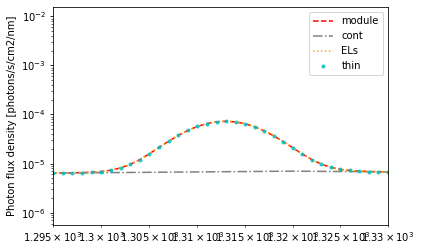

In [217]:
# test Spectrum module 

wave = np.arange(pars['spectral_range'][0], pars['spectral_range'][1], 1)
# expected continuum
cont = np.genfromtxt(pars['template'], dtype=[('lam',float), ('flux', float)])
cont['lam']  = cont['lam']/10*(1+pars['z'])
cont['flux'] /= (Spectrum._h*Spectrum._c/cont['lam'])
norm = np.interp(pars['obs_cont_norm'][0], cont['lam'], cont['flux'])
renorm = pars['obs_cont_norm'][1]*pars['obs_cont_norm'][0]/(Spectrum._h*Spectrum._c)
cont['flux'] = cont['flux']/norm*renorm
# expected emission lines
ELs = np.interp(wave, cont['lam'], cont['flux'])
for line,flux in pars['lines'].items():
    line_std = np.atleast_1d(pars['line_sigma_int'][line])*(1+pars['z'])
    cen = np.atleast_1d(Spectrum._valid_lines[line])*(1+pars['z'])
    flux = np.atleast_1d(flux)*cen/(Spectrum._h*Spectrum._c)\
            /np.sqrt(2*np.pi*line_std**2)
    for i,_cen in enumerate(cen):
        ELs += flux[i]*np.exp(-(wave-_cen)**2/2/line_std[i]**2)
# what we get from Spectrum module
pred = test.spectrum(wave)
pred_thin = test_thin.spectrum(wave)
### show spectrum
fig = plt.figure()
# module prediction
plt.plot(wave, pred, color='r', label='module', ls='--')
plt.errorbar(wave, pred_thin, fmt='.c', label='thin', alpha=0.8)
# expected continuum
plt.plot(cont['lam'], cont['flux'], color='grey', ls='-.', label='cont')
# expected emission lines
plt.plot(wave, ELs, color='orange', ls=':', label='ELs')
# mark the center of build-in lines
#ax = plt.gca()
#for line, cen in Spectrum._valid_lines.items():
#    print(cen)
#    cen = np.atleast_1d(cen)
#    for _cen in cen:
#        plt.plot([_cen*(1+pars['z']), _cen*(1+pars['z'])],
#                 [0.0, 0.001, ], ls='-', color='k')
#        if(line=='Halpha'):
#            plt.text(_cen*(1+pars['z']), 0, line, ha='center', va='top')
#plt.scatter([pars['obs_cont_norm'][0]], 
#            [pars['obs_cont_norm'][1]*pars['obs_cont_norm'][0]/\
#             (Spectrum._h*Spectrum._c)], color='r')
plt.legend()
plt.ylabel('Photon flux density [photons/s/cm2/nm]')

#plt.xlim([700, 800])
#plt.xlim([975, 1025])
plt.xlim([1295, 1330])
#plt.xlim(pars['spectral_range'])

plt.yscale('log')
plt.xscale('log')
plt.show()